In [309]:
import cv2
import os
import numpy as np
import pandas as pd
import spacy
from spacy import displacy
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd="/home/aman/anaconda3/envs/tallyInvoiceParser.env/bin/tesseract"
os.environ['TESSDATA_PREFIX'] = "/home/aman/anaconda3/envs/tallyInvoiceParser.env/share/tessdata"
os.environ['MLIR_CRASH_REPRODUCER_DIRECTORY']='tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269'
import import_ipynb
from textPreProcessor import *
from imagePreProcessor import *
from datetime import datetime
import math
from sklearn.model_selection import train_test_split
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, ReLU, activation, Dropout
import tensorflow as tf

In [310]:
pwd

'/home/aman/Documents/Tally/DocumentAI/Code/Tesseract-Modelv4/Dataset'

In [311]:
os.chdir('/home/aman/Documents/Tally/DocumentAI/Code/Tesseract-Modelv4/Dataset/')

In [312]:
df = pd.read_csv("tesseract.csv")

In [313]:
df.shape

(44, 32)

In [314]:
df.describe()

,Unnamed: 0,block_num,par_num,line_num,word_num,left,top,width,height,conf,...,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,...,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,21.500000,10.318182,1.818182,1.772727,4.409091,813.318182,735.113636,122.750000,21.772727,84.820077,...,1.586886,1.947368,1.921872,1.944005,1.774596,1.880652,1.916398,1.964418,1.962219,0.500000
std,12.845233,7.096585,1.932257,1.008421,2.713602,488.000847,470.935250,22.617265,3.964163,13.587430,...,0.388665,0.197136,0.237383,0.210275,0.374493,0.283910,0.250913,0.165123,0.175374,0.505781
min,0.000000,1.000000,1.000000,1.000000,1.000000,70.000000,86.000000,84.000000,16.000000,47.387981,...,1.113412,1.171141,1.133543,1.121537,1.112432,1.121765,1.115141,1.181516,1.126455,0.000000
25%,10.750000,5.000000,1.000000,1.000000,3.000000,316.500000,353.750000,106.000000,19.000000,78.052681,...,1.172768,2.000000,2.000000,2.000000,1.355890,2.000000,2.000000,2.000000,2.000000,0.000000
50%,21.500000,9.000000,1.000000,2.000000,4.000000,791.000000,561.000000,124.000000,21.500000,89.717541,...,1.488765,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.500000
75%,32.250000,14.250000,1.250000,2.000000,6.000000,1255.750000,1032.500000,132.250000,23.000000,96.127286,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000
max,43.000000,26.000000,9.000000,6.000000,13.000000,2043.000000,1904.000000,165.000000,34.000000,96.851837,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000


In [315]:
len(df["imageName"].unique())

26

In [316]:
def preProcess(df):
    for index in df.index:
        x = df["x"][index]
        y = df["y"][index]
        X = df["PageWidth"][index]
        Y = df["PageHeight"][index]
        
        if x<X//2:
            df["isLeft"][index]=1
        elif x>=X//2:
            df["isRight"][index]=1
            
        if y<Y//2:
            df["isBottom"][index]=1
        elif y>Y//2:
            df["isTop"][index]=1
            
    df["x"]/=df["PageWidth"]
    df["y"]/=df["PageHeight"]
    df["conf"]=df["conf"]/100
        
    colsToDrop = ["Unnamed: 0", "left", "top", "width", "height", "imageName", "text", "PageHeight", "PageWidth", "par_num"]
    df.drop(columns=colsToDrop, inplace=True)
    

In [317]:
preProcess(df)

/tmp/ipykernel_10029/2727983626.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isLeft"][index]=1
/tmp/ipykernel_10029/2727983626.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isBottom"][index]=1
/tmp/ipykernel_10029/2727983626.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isRight"][index]=1
/tmp/ipykernel_10029/2727983626.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [318]:
df

,block_num,line_num,word_num,conf,x,y,isTop,isBottom,isRight,isLeft,...,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
0,7,2,3,0.961913,0.275091,0.482257,0,1,0,1,...,1.494869,2.000000,1.151753,2.000000,2.000000,1.528837,2.000000,2.000000,2.000000,0
1,7,3,4,0.957325,0.927449,0.499786,0,0,1,0,...,1.157799,2.000000,1.814312,2.000000,2.000000,1.131721,2.000000,2.000000,2.000000,1
2,20,2,7,0.696727,0.591898,0.791364,1,0,1,0,...,1.184538,2.000000,2.000000,2.000000,1.162413,1.421152,2.000000,2.000000,2.000000,0
3,26,1,4,0.967881,0.591898,0.821719,1,0,1,0,...,1.159215,2.000000,2.000000,2.000000,1.132623,2.000000,2.000000,2.000000,2.000000,0
4,9,1,3,0.711752,0.408706,0.395896,0,1,0,1,...,2.000000,2.000000,2.000000,2.000000,1.148762,2.000000,2.000000,2.000000,2.000000,0
5,9,1,4,0.642398,0.506046,0.395896,0,1,1,0,...,2.000000,2.000000,2.000000,2.000000,1.139577,2.000000,2.000000,2.000000,2.000000,0
6,9,1,3,0.942344,0.406288,0.451475,0,1,0,1,...,2.000000,2.000000,2.000000,2.000000,1.112512,2.000000,2.000000,2.000000,2.000000,0
7,9,1,4,0.846359,0.503628,0.454468,0,1,1,0,...,2.000000,2.000000,2.000000,2.000000,1.183212,2.000000,2.000000,2.000000,2.000000,0
8,4,2,3,0.708140,0.115882,0.154091,0,1,0,1,...,1.113412,2.000000,2.000000,2.000000,2.000000,1.151256,1.194122,2.000000,2.000000,1
9,9,6,2,0.732693,0.790000,0.159091,0,1,1,0,...,1.171668,2.000000,2.000000,2.000000,1.411681,2.000000,2.000000,1.252860,2.000000,1


In [319]:
df.describe()

,block_num,line_num,word_num,conf,x,y,isTop,isBottom,isRight,isLeft,...,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,...,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,10.318182,1.772727,4.409091,0.848201,0.537860,0.338599,0.159091,0.818182,0.568182,0.431818,...,1.586886,1.947368,1.921872,1.944005,1.774596,1.880652,1.916398,1.964418,1.962219,0.500000
std,7.096585,1.008421,2.713602,0.135874,0.273721,0.219287,0.369989,0.390154,0.501056,0.501056,...,0.388665,0.197136,0.237383,0.210275,0.374493,0.283910,0.250913,0.165123,0.175374,0.505781
min,1.000000,1.000000,1.000000,0.473880,0.082514,0.047273,0.000000,0.000000,0.000000,0.000000,...,1.113412,1.171141,1.133543,1.121537,1.112432,1.121765,1.115141,1.181516,1.126455,0.000000
25%,5.000000,1.000000,3.000000,0.780527,0.274981,0.165455,0.000000,1.000000,0.000000,0.000000,...,1.172768,2.000000,2.000000,2.000000,1.355890,2.000000,2.000000,2.000000,2.000000,0.000000
50%,9.000000,2.000000,4.000000,0.897175,0.542174,0.261860,0.000000,1.000000,1.000000,0.000000,...,1.488765,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.500000
75%,14.250000,2.000000,6.000000,0.961273,0.802059,0.452223,0.000000,1.000000,1.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000
max,26.000000,6.000000,13.000000,0.968518,0.927449,0.964933,1.000000,1.000000,1.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000


In [320]:
df.corr()

,block_num,line_num,word_num,conf,x,y,isTop,isBottom,isRight,isLeft,...,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
block_num,1.000000,0.085082,-0.265351,0.214595,0.189408,0.602140,0.671129,-0.608572,0.255368,-0.255368,...,0.111112,0.116936,0.063004,-0.080755,-0.096383,0.017759,0.101373,0.024714,0.289450,-0.136063
line_num,0.085082,1.000000,-0.152201,-0.029635,0.069052,-0.059290,0.099162,-0.166580,0.077407,-0.077407,...,-0.120385,0.038997,0.069938,0.112457,0.081803,-0.167473,0.027804,-0.352775,0.168918,0.227980
word_num,-0.265351,-0.152201,1.000000,-0.052828,0.363201,-0.118902,-0.135820,0.137786,0.389506,-0.389506,...,0.033782,-0.011651,0.144371,0.005276,0.214528,0.105261,0.001758,0.025836,-0.086550,-0.118610
conf,0.214595,-0.029635,-0.052828,1.000000,0.134531,0.214275,0.108187,-0.150467,0.070878,-0.070878,...,0.058853,-0.146578,0.064360,0.146699,0.006815,0.146751,0.148066,0.007731,0.228021,-0.129111
x,0.189408,0.069052,0.363201,0.134531,1.000000,-0.181387,-0.099165,0.009201,0.896361,-0.896361,...,-0.074855,-0.149054,-0.063151,-0.149646,-0.051765,0.059356,0.180071,-0.229391,0.243209,0.277647
y,0.602140,-0.059290,-0.118902,0.214275,-0.181387,1.000000,0.813291,-0.815072,-0.074953,0.074953,...,0.096320,0.199751,0.049697,-0.044213,-0.219766,-0.072205,0.319339,0.129620,0.194241,-0.481447
isTop,0.671129,0.099162,-0.135820,0.108187,-0.099165,0.813291,1.000000,-0.922687,0.002851,-0.002851,...,-0.028108,0.117469,0.144809,0.117167,-0.021339,-0.117689,0.146600,0.094813,0.094787,-0.186411
isBottom,-0.608572,-0.166580,0.137786,-0.150467,0.009201,-0.815072,-0.922687,1.000000,-0.054074,0.054074,...,0.092462,-0.127312,-0.110317,-0.126984,-0.015641,0.268844,-0.158884,-0.102757,-0.102729,0.117851
isRight,0.255368,0.077407,0.389506,0.070878,0.896361,-0.074953,0.002851,-0.054074,1.000000,-1.000000,...,-0.032799,-0.064026,0.045023,-0.076162,-0.104714,0.107625,0.181441,-0.190031,0.249973,0.229416
isLeft,-0.255368,-0.077407,-0.389506,-0.070878,-0.896361,0.074953,-0.002851,0.054074,-1.000000,1.000000,...,0.032799,0.064026,-0.045023,0.076162,0.104714,-0.107625,-0.181441,0.190031,-0.249973,-0.229416


In [321]:
df.shape

(44, 22)

In [322]:
def extractData(df):
    train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
    xTrain = train.drop(columns = ["output"]).to_numpy()
    xTest = test.drop(columns = ["output"]).to_numpy()
    yTrain = train["output"].to_numpy()
    yTest = test["output"].to_numpy()
    return xTrain, yTrain, xTest, yTest

In [323]:
xTrain, yTrain, xTest, yTest = extractData(df)

In [324]:
xTrain.shape

(35, 21)

In [325]:
xTest.shape

(9, 21)

In [326]:
yTrain.shape

(35,)

In [327]:
type(xTrain)

numpy.ndarray

In [328]:
type(yTrain)

numpy.ndarray

In [329]:
model = keras.Sequential([
    keras.layers.Dense(16, input_shape=(21, ), activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

In [330]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 16)                352       
                                                                 
 dense_88 (Dense)            (None, 16)                272       
                                                                 
 dense_89 (Dense)            (None, 1)                 17        
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [331]:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=["accuracy", 'Precision', "Recall", "TruePositives", "TrueNegatives", "FalsePositives", "FalseNegatives"])

In [332]:
history = model.fit(xTrain, yTrain,
          epochs=100, batch_size=1)

Epoch 1/100
35/35 [==============================] - 1s 920us/step - loss: 0.8669 - accuracy: 0.4571 - precision: 0.0000e+00 - recall: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 16.0000 - false_positives: 1.0000 - false_negatives: 18.0000     
Epoch 2/100
35/35 [==============================] - 0s 932us/step - loss: 0.7353 - accuracy: 0.4857 - precision: 0.5000 - recall: 0.4444 - true_positives: 8.0000 - true_negatives: 9.0000 - false_positives: 8.0000 - false_negatives: 10.0000             
Epoch 3/100
35/35 [==============================] - 0s 962us/step - loss: 0.6978 - accuracy: 0.6286 - precision: 0.6316 - recall: 0.6667 - true_positives: 12.0000 - true_negatives: 10.0000 - false_positives: 7.0000 - false_negatives: 6.0000            
Epoch 4/100
35/35 [==============================] - 0s 997us/step - loss: 0.6766 - accuracy: 0.5714 - precision: 0.5600 - recall: 0.7778 - true_positives: 14.0000 - true_negatives: 6.0000 - false_positives: 11.0000 - false_negatives

35/35 [==============================] - 0s 956us/step - loss: 0.4002 - accuracy: 0.8857 - precision: 0.8889 - recall: 0.8889 - true_positives: 16.0000 - true_negatives: 15.0000 - false_positives: 2.0000 - false_negatives: 2.0000    
Epoch 34/100
35/35 [==============================] - 0s 983us/step - loss: 0.3752 - accuracy: 0.9429 - precision: 1.0000 - recall: 0.8889 - true_positives: 16.0000 - true_negatives: 17.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000        
Epoch 35/100
35/35 [==============================] - 0s 962us/step - loss: 0.3796 - accuracy: 0.8857 - precision: 0.9375 - recall: 0.8333 - true_positives: 15.0000 - true_negatives: 16.0000 - false_positives: 1.0000 - false_negatives: 3.0000    
Epoch 36/100
35/35 [==============================] - 0s 993us/step - loss: 0.3733 - accuracy: 0.9429 - precision: 0.9444 - recall: 0.9444 - true_positives: 17.0000 - true_negatives: 16.0000 - false_positives: 1.0000 - false_negatives: 1.0000            
Epoch 37/

35/35 [==============================] - 0s 1ms/step - loss: 0.2163 - accuracy: 0.9714 - precision: 0.9474 - recall: 1.0000 - true_positives: 18.0000 - true_negatives: 16.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00  
Epoch 66/100
35/35 [==============================] - 0s 971us/step - loss: 0.2261 - accuracy: 0.9429 - precision: 0.9444 - recall: 0.9444 - true_positives: 17.0000 - true_negatives: 16.0000 - false_positives: 1.0000 - false_negatives: 1.0000            
Epoch 67/100
35/35 [==============================] - 0s 965us/step - loss: 0.2545 - accuracy: 0.9429 - precision: 0.9444 - recall: 0.9444 - true_positives: 17.0000 - true_negatives: 16.0000 - false_positives: 1.0000 - false_negatives: 1.0000            
Epoch 68/100
35/35 [==============================] - 0s 1ms/step - loss: 0.1892 - accuracy: 0.9714 - precision: 0.9474 - recall: 1.0000 - true_positives: 18.0000 - true_negatives: 16.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00  
Epoch 69/

35/35 [==============================] - 0s 959us/step - loss: 0.1288 - accuracy: 0.9714 - precision: 1.0000 - recall: 0.9444 - true_positives: 17.0000 - true_negatives: 17.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 98/100
35/35 [==============================] - 0s 959us/step - loss: 0.1359 - accuracy: 0.9429 - precision: 0.9444 - recall: 0.9444 - true_positives: 17.0000 - true_negatives: 16.0000 - false_positives: 1.0000 - false_negatives: 1.0000    
Epoch 99/100
35/35 [==============================] - 0s 938us/step - loss: 0.1333 - accuracy: 0.9714 - precision: 0.9474 - recall: 1.0000 - true_positives: 18.0000 - true_negatives: 16.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00    
Epoch 100/100
35/35 [==============================] - 0s 926us/step - loss: 0.1338 - accuracy: 0.9714 - precision: 1.0000 - recall: 0.9444 - true_positives: 17.0000 - true_negatives: 17.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000


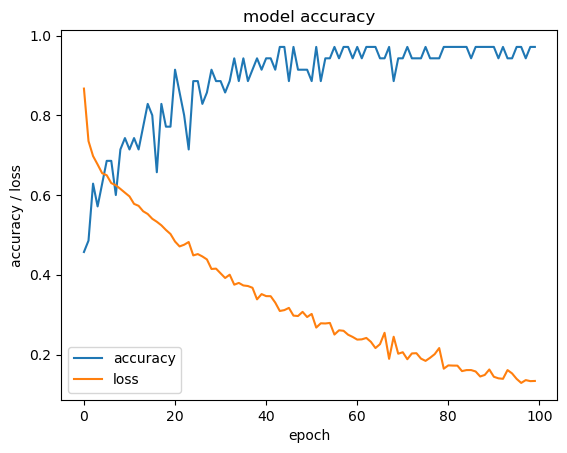

In [333]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.legend(["accuracy", "loss"])
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.show()

In [308]:
model.evaluate(xTest, yTest)

1/1 [==============================] - 0s 244ms/step - loss: 0.6764 - accuracy: 0.7778 - precision: 1.0000 - recall: 0.5000 - true_positives: 2.0000 - true_negatives: 5.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000


[0.6763617992401123, 0.7777777910232544, 1.0, 0.5, 2.0, 5.0, 0.0, 2.0]

In [238]:
pwd

'/home/aman/Documents/Tally/DocumentAI/Code/Tesseract-Modelv4/Dataset'

In [57]:
os.chdir('/home/aman/Documents/Tally/DocumentAI/Code/Tesseract-Modelv4/Models/')

In [ ]:
model.save("tesseractv4.h5")